<a href="https://colab.research.google.com/github/haroldeustaquio/Supermarket-Sales-Tracker-Mx/blob/updates/sales-drink/time-series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Caso de Negocio

Una empresa de distribución de bebidas enfrenta una necesidad de optimizar su planificación financiera y evaluar el desempeño de cada tienda. Actualmente, la falta de visibilidad sobre los ingresos mensuales limita la capacidad de la empresa para tomar decisiones informadas sobre inversiones, promociones y estrategias de ventas. Por ello, se busca implementar un modelo de pronóstico que analice los ingresos mensuales por tienda, utilizando datos históricos de ventas. Este enfoque permitirá anticipar posibles fluctuaciones  y establecer metas más realistas para cada tienda, facilitando una asignación más efectiva de recursos.

### Preparación de Ambiente

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Cargar Dataframe

In [ ]:
df = pd.read_csv('data/sales-drink.csv', encoding='latin-1')
df.columns = df.columns.str.lower()

In [ ]:
print('Tamaño del dataset: ',df.shape)

Tamaño del dataset:  (52672, 15)


In [ ]:
df.head(2)

,pedido,tienda,fecha,sabor,marca,segmento,segmento_desc,municipio,producto,producto_desc,unidades,monto,prom_temperatura,precio_unidad,contador
0,1000244507,1000043345,06-07-13,MANZANA,DEL VALLE,110,EXTRA GRANDE BAJO AUDITABLE,GUADALUPE,9322,JDV Manz Nec 100 m,24,48.0,31.9,2.0,1
1,1000242608,1000043345,02-07-13,MANGO,DEL VALLE,110,EXTRA GRANDE BAJO AUDITABLE,GUADALUPE,9321,JDV Mango Nec 100,24,48.0,26.5,2.0,1


### Limpieza y Transformación de Datos

In [ ]:
df['total_por_pedido'] = df['unidades']*df['monto']

df['fecha'] = pd.to_datetime(df['fecha'],format='%d-%m-%y')
df['fecha'] = df['fecha'].dt.strftime('%Y-%m-01')

In [ ]:
dicc = {
    1000043345: 'Tienda 1',
    1000050643: 'Tienda 2',
    1000038155: 'Tienda 3',
    1000005887: 'Tienda 4',
    1000007403: 'Tienda 5',
    1000071011: 'Tienda 6'
}
df['tienda'] = df['tienda'].replace(dicc)

In [ ]:
final_df = df.groupby(['tienda','fecha']).agg({
    'monto_total':'sum'
}
).sort_values(by=['tienda','fecha']).reset_index()

In [ ]:
final_df

,tienda,fecha,total_por_pedido
0,Tienda 1,2012-01-01,1610631.67
1,Tienda 1,2012-02-01,1591641.93
2,Tienda 1,2012-03-01,2533074.03
3,Tienda 1,2012-04-01,2738859.82
4,Tienda 1,2012-05-01,2879172.03
...,...,...,...
175,Tienda 6,2014-02-01,537247.74
176,Tienda 6,2014-03-01,291373.56
177,Tienda 6,2014-04-01,256601.44
178,Tienda 6,2014-05-01,432256.94


## ARIMA


In [ ]:
def plot_acf_q(store):
    plot_acf(store['monto_total'])
    plt.title('ACF Plot')
    plt.show()

def plot_pacf_p(store):
    plot_pacf(store['monto_total'])
    plt.title('PACF Plot')
    plt.show()

In [ ]:
def arima_per_store(group,p=1,d=1,q=1):
    model = ARIMA(group, order=(p,d,q))  # Cambia los parámetros p, d, q si es necesario
    model_fit = model.fit()

    # Mostrar los resultados del resumen
    print(model_fit.summary())

    # Graficar el ajuste del modelo
    model_fit.plot_diagnostics(figsize=(10,8))
    plt.tight_layout()
    plt.show()

In [ ]:
def AIC(store):
# Comparar diferentes combinaciones de p, d, q
    aic_values = []
    for p in range(0, 3):  # Cambia el rango según sea necesario
        for d in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(store['monto_total'], order=(p, d, q))
                    model_fit = model.fit()
                    aic_values.append((p, d, q, model_fit.aic))
                except:
                    continue

    # Crear un DataFrame para visualizar los resultados
    aic_df = pd.DataFrame(aic_values, columns=['p', 'd', 'q', 'AIC'])
    sorted_aic_df = aic_df.sort_values('AIC').reset_index(drop=True)
    print(sorted_aic_df)
    p,d,q = sorted_aic_df.iloc[0,0:3].values
    return p,d,q

### Tienda 1

In [ ]:
tienda_1 = final_df[final_df['tienda']=='Tienda 1']

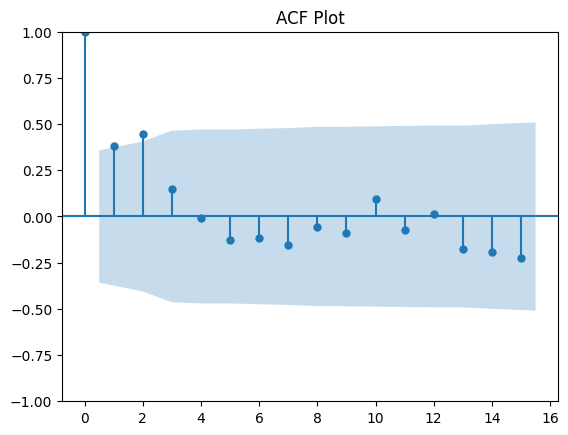

In [ ]:
plot_acf_q(tienda_1)

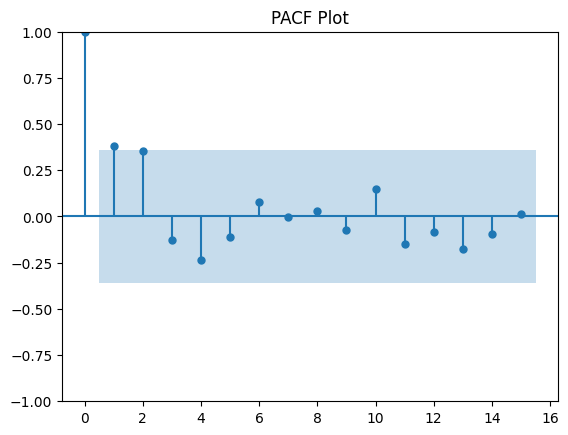

In [ ]:
plot_pacf_p(tienda_1)

In [ ]:
p,d,q = AIC(tienda_1)

g:\Supermarket-Sales-Tracker-Mx\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
g:\Supermarket-Sales-Tracker-Mx\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
g:\Supermarket-Sales-Tracker-Mx\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
g:\Supermarket-Sales-Tracker-Mx\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

    p  d  q         AIC
0   2  2  0  849.829892
1   1  2  1  850.686612
2   2  2  1  851.652366
3   1  2  2  853.076650
4   2  2  2  854.168754
5   1  2  0  856.359447
6   0  2  2  856.676978
7   0  2  1  862.927842
8   0  1  2  872.314062
9   1  1  2  873.934860
10  2  1  2  875.209168
11  1  1  0  875.379243
12  2  1  0  876.620032
13  1  1  1  877.021909
14  2  1  1  878.031285
15  0  1  1  879.092192
16  0  1  0  882.981387
17  0  2  0  884.446379
18  1  0  2  901.274609
19  2  0  2  902.806661
20  0  0  2  903.789202
21  2  0  0  905.099866
22  2  0  1  906.743504
23  1  0  0  907.414323
24  1  0  1  907.925780
25  0  0  1  909.939510
26  0  0  0  983.531000


Modelando para la tienda: Tienda 1
                               SARIMAX Results                                
Dep. Variable:       total_por_pedido   No. Observations:                   30
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -421.915
Date:                Mon, 14 Oct 2024   AIC                            849.830
Time:                        22:48:50   BIC                            853.827
Sample:                             0   HQIC                           851.052
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2442      0.174     -7.167      0.000      -1.584      -0.904
ar.L2         -0.5271      0.172     -3.065      0.002      -0.864      -0.190
sigma2       7.63

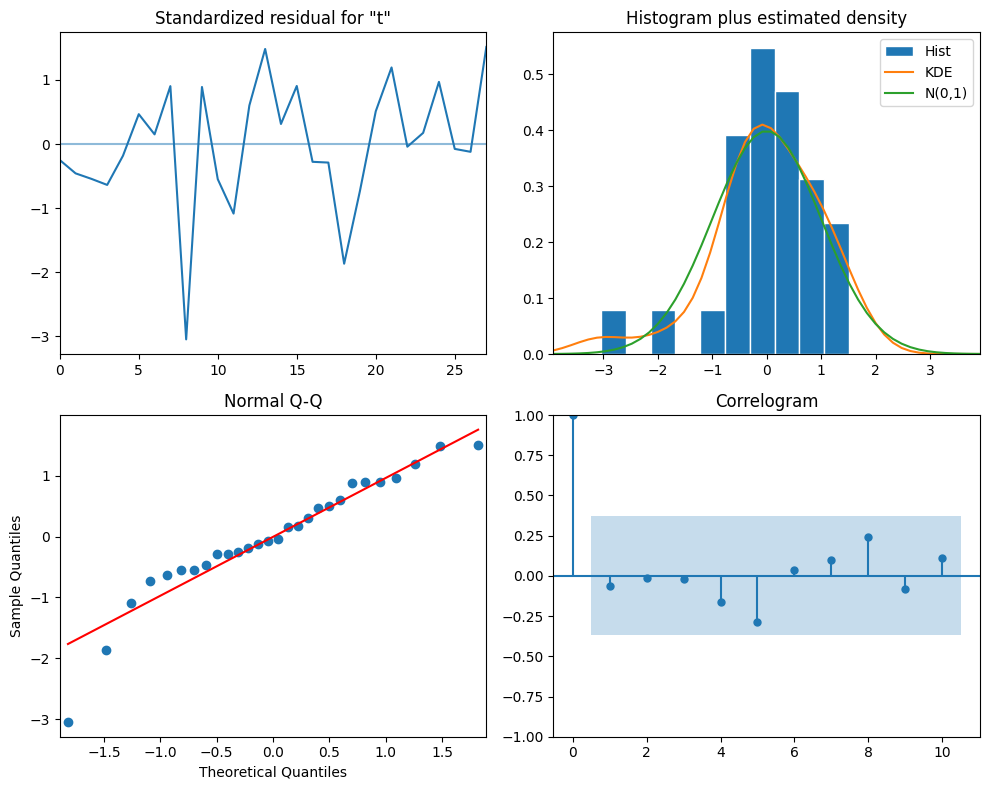

In [ ]:
grouped = tienda_1.groupby('tienda')

for store, group in grouped:
    print(f"Modelando para la tienda: {store}")
    arima_per_store(group['monto_total'],p,d,q)


# Evaluación de resultados

# Conclusiones